In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'food11-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F432700%2F821742%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T102609Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1882df18af1c4baef3679068e94da144c112b29d5ebc81a49dde52bea239f3d777a0f6c65073bef2e9bd142bb91ef4b701e4ec7bc746c1f6e6cdeaa654ba9bfec88b6fe84bb09dbc40bf8b7812aa7e58458d685cb2bdf6ffd112d528b6850de2642cf2b14a85b4bacd3a584bc3006e16511f1c4e2deeaea99207f15916bf32b8dadedade3c41f864355a0a9b2be7cf5133f31f9d8a62dbbab815332033118ff6af1bd68b1389fe819a4233d5f296330d5fbe67c5dafbbfe50c6a921d8152dea96535c815c18b103377036bdc3712f0cb1642b461e871a243923294fb70c8172387c0408a17f0bc9547b1347ec94e9ce79603939312154f4d9316125007bfdad2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1163229310 bytes downloaded
Downloaded and uncompressed: food11-image-dataset
Data source import complete.


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [ ]:
ROOT_PATH = '/kaggle/input/food11-image-dataset'
training_path = f'{ROOT_PATH}/training'
validation_path = f'{ROOT_PATH}/validation'
evaluation_path = f'{ROOT_PATH}/evaluation'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
batch_size = 32
image_size = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing()
])

In [ ]:
model = models.resnet34(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 80.8MB/s]


In [ ]:
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, 11, device)

In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


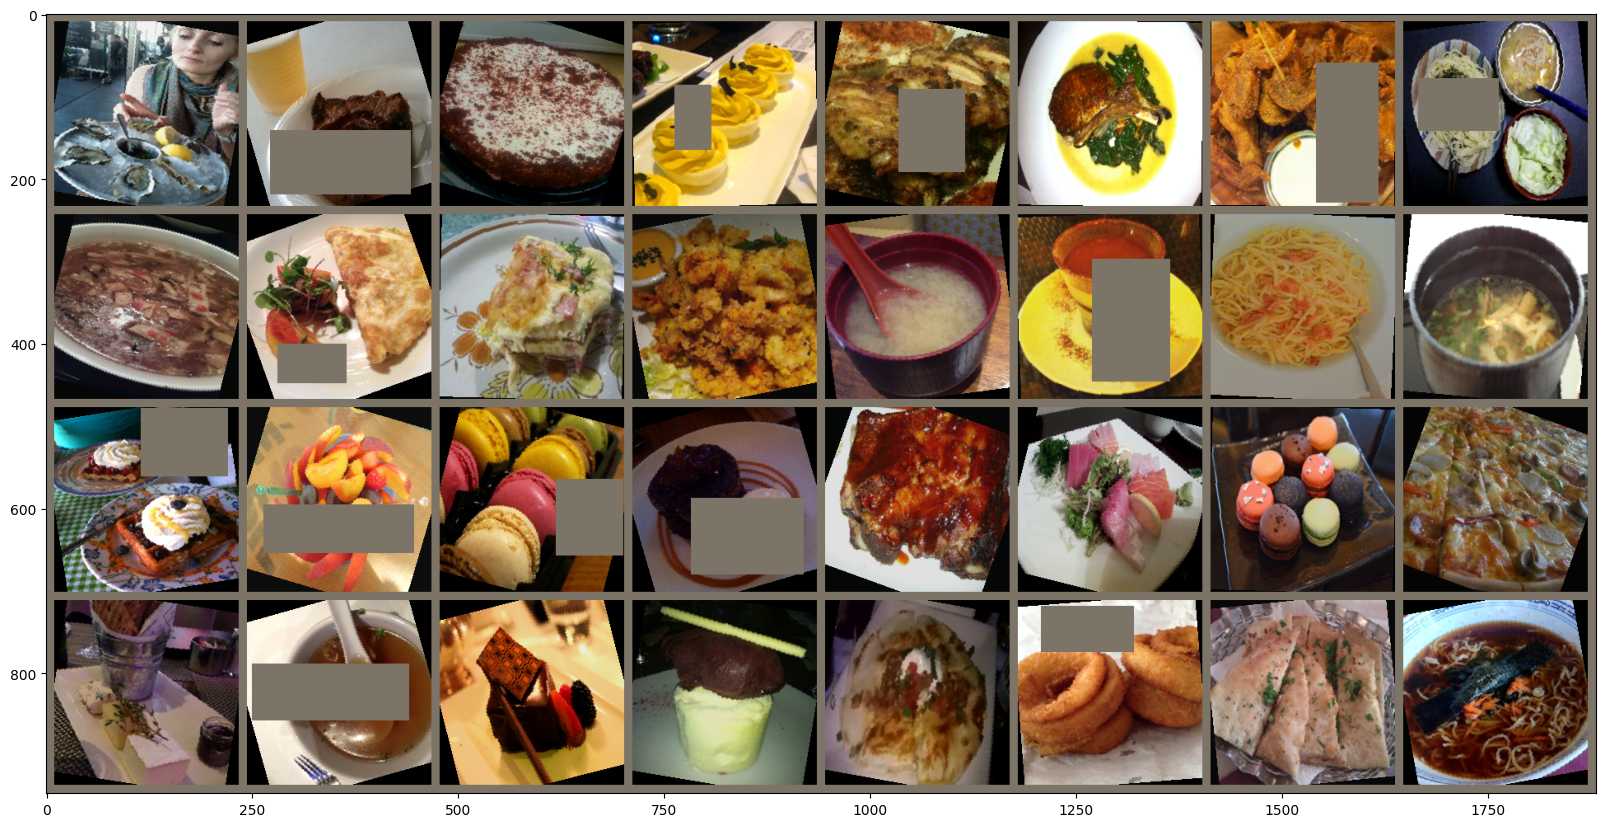

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
    np_image = np.array(images).transpose((1, 2, 0))
    unnorm_image = np_image * std + mean
    plt.figure(figsize=(20, 20))
    plt.imshow(unnorm_image)

imshow(grid_images, mean, std)

In [ ]:
num_epochs = 15
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(tqdm(train_dataloader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f' % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item()))

 16%|█▌        | 50/309 [00:14<01:06,  3.90it/s]

Epoch [ 1/15], Step [ 50/308], Loss: 1.5425


 32%|███▏      | 100/309 [00:28<01:08,  3.04it/s]

Epoch [ 1/15], Step [100/308], Loss: 0.7845


 49%|████▊     | 150/309 [00:41<00:54,  2.91it/s]

Epoch [ 1/15], Step [150/308], Loss: 0.6954


 65%|██████▍   | 200/309 [00:54<00:35,  3.04it/s]

Epoch [ 1/15], Step [200/308], Loss: 0.4335


 81%|████████  | 250/309 [01:07<00:19,  3.04it/s]

Epoch [ 1/15], Step [250/308], Loss: 0.7265


 97%|█████████▋| 300/309 [01:20<00:02,  3.10it/s]

Epoch [ 1/15], Step [300/308], Loss: 0.5906


 16%|█▌        | 50/309 [00:12<01:05,  3.93it/s]

Epoch [ 2/15], Step [ 50/308], Loss: 0.5884


 32%|███▏      | 100/309 [00:25<00:57,  3.64it/s]

Epoch [ 2/15], Step [100/308], Loss: 0.5192


 49%|████▊     | 150/309 [00:38<00:56,  2.83it/s]

Epoch [ 2/15], Step [150/308], Loss: 0.2176


 65%|██████▍   | 200/309 [00:52<00:28,  3.77it/s]

Epoch [ 2/15], Step [200/308], Loss: 0.2863


 81%|████████  | 250/309 [01:04<00:16,  3.58it/s]

Epoch [ 2/15], Step [250/308], Loss: 0.1355


 97%|█████████▋| 300/309 [01:17<00:02,  3.99it/s]

Epoch [ 2/15], Step [300/308], Loss: 0.1587


 16%|█▌        | 50/309 [00:13<01:02,  4.12it/s]

Epoch [ 3/15], Step [ 50/308], Loss: 0.3322


 32%|███▏      | 100/309 [00:26<00:49,  4.24it/s]

Epoch [ 3/15], Step [100/308], Loss: 0.4430


 49%|████▊     | 150/309 [00:39<00:40,  3.89it/s]

Epoch [ 3/15], Step [150/308], Loss: 0.4047


 65%|██████▍   | 200/309 [00:52<00:28,  3.85it/s]

Epoch [ 3/15], Step [200/308], Loss: 0.6903


 81%|████████  | 250/309 [01:05<00:15,  3.83it/s]

Epoch [ 3/15], Step [250/308], Loss: 0.3573


 97%|█████████▋| 300/309 [01:18<00:02,  4.07it/s]

Epoch [ 3/15], Step [300/308], Loss: 0.2386


 16%|█▌        | 50/309 [00:13<01:10,  3.65it/s]

Epoch [ 4/15], Step [ 50/308], Loss: 0.1984


 32%|███▏      | 100/309 [00:26<01:00,  3.44it/s]

Epoch [ 4/15], Step [100/308], Loss: 0.3821


 49%|████▊     | 150/309 [00:38<00:40,  3.89it/s]

Epoch [ 4/15], Step [150/308], Loss: 0.4695


 65%|██████▍   | 200/309 [00:51<00:26,  4.06it/s]

Epoch [ 4/15], Step [200/308], Loss: 0.1026


 81%|████████  | 251/309 [01:05<00:12,  4.73it/s]

Epoch [ 4/15], Step [250/308], Loss: 0.1468


 97%|█████████▋| 301/309 [01:18<00:01,  4.61it/s]

Epoch [ 4/15], Step [300/308], Loss: 0.1604


 16%|█▌        | 50/309 [00:13<01:41,  2.55it/s]

Epoch [ 5/15], Step [ 50/308], Loss: 0.4906


 32%|███▏      | 100/309 [00:25<01:15,  2.76it/s]

Epoch [ 5/15], Step [100/308], Loss: 0.3537


 49%|████▊     | 150/309 [00:38<00:58,  2.73it/s]

Epoch [ 5/15], Step [150/308], Loss: 0.1667


 65%|██████▍   | 200/309 [00:51<00:36,  2.95it/s]

Epoch [ 5/15], Step [200/308], Loss: 0.2664


 81%|████████  | 250/309 [01:04<00:18,  3.26it/s]

Epoch [ 5/15], Step [250/308], Loss: 0.1163


 97%|█████████▋| 301/309 [01:17<00:01,  4.09it/s]

Epoch [ 5/15], Step [300/308], Loss: 0.1855


 16%|█▌        | 50/309 [00:13<01:04,  4.01it/s]

Epoch [ 6/15], Step [ 50/308], Loss: 0.3057


 32%|███▏      | 100/309 [00:26<00:59,  3.53it/s]

Epoch [ 6/15], Step [100/308], Loss: 0.1600


 49%|████▊     | 150/309 [00:39<00:45,  3.52it/s]

Epoch [ 6/15], Step [150/308], Loss: 0.3317


 65%|██████▍   | 200/309 [00:52<00:29,  3.74it/s]

Epoch [ 6/15], Step [200/308], Loss: 0.1133


 81%|████████  | 250/309 [01:04<00:15,  3.81it/s]

Epoch [ 6/15], Step [250/308], Loss: 0.1792


 97%|█████████▋| 300/309 [01:19<00:02,  3.82it/s]

Epoch [ 6/15], Step [300/308], Loss: 0.3890


 17%|█▋        | 51/309 [00:13<00:55,  4.62it/s]

Epoch [ 7/15], Step [ 50/308], Loss: 0.3603


 33%|███▎      | 101/309 [00:26<00:48,  4.30it/s]

Epoch [ 7/15], Step [100/308], Loss: 0.3695


 49%|████▊     | 150/309 [00:39<00:41,  3.80it/s]

Epoch [ 7/15], Step [150/308], Loss: 0.1302


 65%|██████▌   | 201/309 [00:51<00:23,  4.68it/s]

Epoch [ 7/15], Step [200/308], Loss: 0.0765


 81%|████████  | 250/309 [01:04<00:15,  3.84it/s]

Epoch [ 7/15], Step [250/308], Loss: 0.1214


 97%|█████████▋| 300/309 [01:17<00:02,  3.61it/s]

Epoch [ 7/15], Step [300/308], Loss: 0.2910


 16%|█▌        | 50/309 [00:13<01:06,  3.91it/s]

Epoch [ 8/15], Step [ 50/308], Loss: 0.1901


 32%|███▏      | 100/309 [00:25<00:53,  3.93it/s]

Epoch [ 8/15], Step [100/308], Loss: 0.1617


 49%|████▊     | 150/309 [00:39<00:43,  3.64it/s]

Epoch [ 8/15], Step [150/308], Loss: 0.1713


 65%|██████▌   | 201/309 [00:51<00:25,  4.25it/s]

Epoch [ 8/15], Step [200/308], Loss: 0.1066


 81%|████████  | 251/309 [01:05<00:20,  2.90it/s]

Epoch [ 8/15], Step [250/308], Loss: 0.2576


 97%|█████████▋| 301/309 [01:17<00:02,  3.60it/s]

Epoch [ 8/15], Step [300/308], Loss: 0.1387


 17%|█▋        | 51/309 [00:13<00:58,  4.40it/s]

Epoch [ 9/15], Step [ 50/308], Loss: 0.1603


 33%|███▎      | 101/309 [00:25<00:53,  3.91it/s]

Epoch [ 9/15], Step [100/308], Loss: 0.0565


 49%|████▊     | 150/309 [00:39<00:50,  3.15it/s]

Epoch [ 9/15], Step [150/308], Loss: 0.0614


 65%|██████▍   | 200/309 [00:52<00:31,  3.47it/s]

Epoch [ 9/15], Step [200/308], Loss: 0.0846


 81%|████████  | 250/309 [01:05<00:18,  3.18it/s]

Epoch [ 9/15], Step [250/308], Loss: 0.1734


 97%|█████████▋| 300/309 [01:18<00:02,  3.66it/s]

Epoch [ 9/15], Step [300/308], Loss: 0.1646


 16%|█▌        | 50/309 [00:13<01:25,  3.03it/s]

Epoch [10/15], Step [ 50/308], Loss: 0.2091


 32%|███▏      | 100/309 [00:27<00:52,  4.00it/s]

Epoch [10/15], Step [100/308], Loss: 0.0656


 49%|████▊     | 150/309 [00:40<00:36,  4.37it/s]

Epoch [10/15], Step [150/308], Loss: 0.1402


 65%|██████▍   | 200/309 [00:53<00:28,  3.82it/s]

Epoch [10/15], Step [200/308], Loss: 0.1980


 81%|████████  | 250/309 [01:06<00:14,  4.10it/s]

Epoch [10/15], Step [250/308], Loss: 0.1748


 97%|█████████▋| 300/309 [01:19<00:02,  3.99it/s]

Epoch [10/15], Step [300/308], Loss: 0.1672


 16%|█▌        | 50/309 [00:13<01:09,  3.73it/s]

Epoch [11/15], Step [ 50/308], Loss: 0.0668


 32%|███▏      | 100/309 [00:26<00:59,  3.54it/s]

Epoch [11/15], Step [100/308], Loss: 0.0693


 49%|████▊     | 150/309 [00:39<00:43,  3.63it/s]

Epoch [11/15], Step [150/308], Loss: 0.1417


 65%|██████▍   | 200/309 [00:52<00:27,  3.97it/s]

Epoch [11/15], Step [200/308], Loss: 0.1562


 81%|████████  | 250/309 [01:05<00:16,  3.51it/s]

Epoch [11/15], Step [250/308], Loss: 0.1511


 97%|█████████▋| 300/309 [01:17<00:02,  3.72it/s]

Epoch [11/15], Step [300/308], Loss: 0.0680


 16%|█▌        | 50/309 [00:14<01:44,  2.48it/s]

Epoch [12/15], Step [ 50/308], Loss: 0.2227


 32%|███▏      | 100/309 [00:27<01:14,  2.82it/s]

Epoch [12/15], Step [100/308], Loss: 0.0509


 49%|████▉     | 151/309 [00:40<00:39,  3.99it/s]

Epoch [12/15], Step [150/308], Loss: 0.0516


 65%|██████▍   | 200/309 [00:53<00:28,  3.77it/s]

Epoch [12/15], Step [200/308], Loss: 0.1178


 81%|████████  | 250/309 [01:06<00:19,  3.05it/s]

Epoch [12/15], Step [250/308], Loss: 0.2372


 97%|█████████▋| 300/309 [01:18<00:02,  3.00it/s]

Epoch [12/15], Step [300/308], Loss: 0.1103


 16%|█▌        | 50/309 [00:13<01:06,  3.90it/s]

Epoch [13/15], Step [ 50/308], Loss: 0.1337


 33%|███▎      | 101/309 [00:27<00:46,  4.52it/s]

Epoch [13/15], Step [100/308], Loss: 0.0973


 49%|████▊     | 150/309 [00:39<00:46,  3.44it/s]

Epoch [13/15], Step [150/308], Loss: 0.1772


 65%|██████▍   | 200/309 [00:52<00:28,  3.88it/s]

Epoch [13/15], Step [200/308], Loss: 0.3166


 81%|████████  | 250/309 [01:05<00:14,  4.09it/s]

Epoch [13/15], Step [250/308], Loss: 0.0453


 97%|█████████▋| 301/309 [01:17<00:01,  4.27it/s]

Epoch [13/15], Step [300/308], Loss: 0.0156


 17%|█▋        | 51/309 [00:13<00:58,  4.42it/s]

Epoch [14/15], Step [ 50/308], Loss: 0.1848


 32%|███▏      | 100/309 [00:25<01:00,  3.45it/s]

Epoch [14/15], Step [100/308], Loss: 0.1289


 49%|████▊     | 150/309 [00:38<00:39,  4.03it/s]

Epoch [14/15], Step [150/308], Loss: 0.0653


 65%|██████▍   | 200/309 [00:50<00:26,  4.04it/s]

Epoch [14/15], Step [200/308], Loss: 0.0336


 81%|████████  | 250/309 [01:03<00:15,  3.75it/s]

Epoch [14/15], Step [250/308], Loss: 0.0555


 97%|█████████▋| 300/309 [01:17<00:02,  4.00it/s]

Epoch [14/15], Step [300/308], Loss: 0.1030


 16%|█▌        | 50/309 [00:14<01:22,  3.14it/s]

Epoch [15/15], Step [ 50/308], Loss: 0.0775


 32%|███▏      | 100/309 [00:26<00:51,  4.06it/s]

Epoch [15/15], Step [100/308], Loss: 0.0960


 49%|████▊     | 150/309 [00:39<00:42,  3.70it/s]

Epoch [15/15], Step [150/308], Loss: 0.0516


 65%|██████▍   | 200/309 [00:52<00:29,  3.71it/s]

Epoch [15/15], Step [200/308], Loss: 0.0194


 81%|████████  | 250/309 [01:05<00:14,  4.18it/s]

Epoch [15/15], Step [250/308], Loss: 0.0992


 97%|█████████▋| 301/309 [01:18<00:01,  4.64it/s]

Epoch [15/15], Step [300/308], Loss: 0.0523


100%|██████████| 309/309 [01:20<00:00,  3.85it/s]


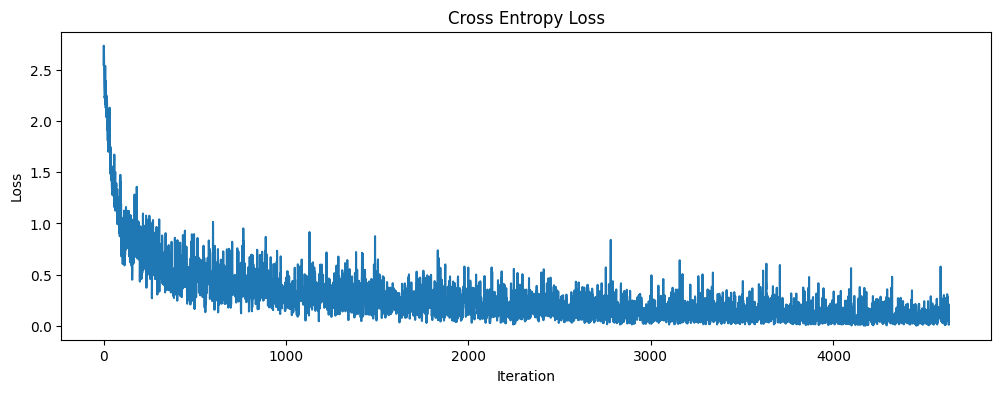

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss')
plt.show()

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    print(f'accuracy: {100.0 * corrects / len(dataloader.dataset)}')

In [ ]:
evaluate_model(model, evaluation_dataloader, device)

accuracy: 92.65013885498047
